In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from PredictXANES import xanes_derivatives

In [12]:
#
#
# There are two derivatives functions, one for noise and one for 0 noise.  
# 
#

def derivatives_zero_noise(mu_df, dx=0.80808080808):
    '''
    Calculates and returns the first and second derivative of the spectra - only used when there is zero noise.
    '''

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)-1])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)-2])

    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)-1):
            dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)-2):
            dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx
            
    dmu1_2 = pd.concat([dmu1, dmu2], axis=1)

    return dmu1, dmu2, dmu1_2

def derivatives_noise(features, dx=0.80808080808):
    '''
    raw_spectra applies noise and smooths the spectra then returns the smoothed spectra 'features', this functions uses 
    the smoothed spectra to calculate the first derivative, smooth the first derivative, then calculate the second derivative.
    It returns the smoothed first derivative and the calculated second derivative.
    '''
    
    dmu1 = np.zeros([len(features), len(features.columns)-1])
    dmu2 = np.zeros([len(features), len(features.columns)-2])
    
    if len(features.columns) == 1000:
        dx =0.1*dx

    for i in range(len(features)):
        for j in range(len(features.columns)-1):
            dmu1[i, j] = (features.iloc[i, j+1] - features.iloc[i, j]) / dx
    
    dmu1 = pd.DataFrame(dmu1)
    for index, row in dmu1.iterrows():
        dmu1.loc[index, :] = savgol_filter(row, 51,2)
    dmu1 = np.asarray(dmu1)

    for i_ in range(len(features)):
        for j_ in range(len(features.columns)-2):
            dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx
            
    dmu1_2 = pd.concat([dmu1, dmu2], axis=1)

    return dmu1, dmu2, dm1_2    

#
# Run train layer to train multiple epochs, find the best epoch will then train using the best epoch 
# analyse_layer will then return loss data, append_data_to_list then stores the loss data 
# and finally plot_data will plot parity plots for each feature. run_layer calls all these functions 
#

def train_layer(X_train, y_train):
    '''
    train_layer trains the neural network. One layer is added, and the depth of the that layer is optimized by 
    looking at the loss from a range of 1 to 100, the maximum number of features being trained on.
    '''
    
    loss = []
    for i in range(100):
        if i == 0:
            pass
        else:
            nn = MLPRegressor(hidden_layer_sizes=(i), activation='identity', solver='lbfgs', max_iter=2000, 
                              random_state=28)
            nn = nn.fit(X_train, y_train)
            loss.append(nn.loss_)

    lossdf = pd.DataFrame(loss)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        print(lossdf)
    return lossdf

def find_best_epoch(lossdf, X_train, y_train):
    '''
    find_best_epoch is a function to return the epoch with the lowest loss, and the loss value
    '''
    
    min_loss = lossdf.idxmin()[0]+1
    print(min_loss)
    best_nn = MLPRegressor(hidden_layer_sizes=(min_loss), activation='identity', solver='lbfgs', max_iter=2000, 
                           random_state=28)
    best_nn = best_nn.fit(X_train, y_train)
    loss = best_nn.loss_
    print(loss)
    
    return min_loss, loss, best_nn

def analyse_layer(X_train, X_test, y_train, y_test, best_nn):
    '''
    analyse_layer returns the training mse and r2 values for the layer in the neural network
    '''
    
    y_train_pred = best_nn.predict(X_train)
    y_test_pred = best_nn.predict(X_test)
    train_score_CN = r2_score(y_train.iloc[:,0], y_train_pred[:,0])
    train_score_Cu = r2_score(y_train.iloc[:,1], y_train_pred[:,1]) 
    train_score_Te = r2_score(y_train.iloc[:,2], y_train_pred[:,2])
    test_score_CN = r2_score(y_test.iloc[:,0], y_test_pred[:,0])
    test_score_Cu = r2_score(y_test.iloc[:,1], y_test_pred[:,1])
    test_score_Te = r2_score(y_test.iloc[:,2], y_test_pred[:,2])
    train_mse_CN = mean_squared_error(y_train.iloc[:,0], y_train_pred[:,0])
    train_mse_Cu = mean_squared_error(y_train.iloc[:,1], y_train_pred[:,1])
    train_mse_Te = mean_squared_error(y_train.iloc[:,2], y_train_pred[:,2])
    test_mse_CN = mean_squared_error(y_test.iloc[:,0], y_test_pred[:,0])
    test_mse_Cu = mean_squared_error(y_test.iloc[:,1], y_test_pred[:,1])
    test_mse_Te = mean_squared_error(y_test.iloc[:,2], y_test_pred[:,2])

    train_score_list = [train_score_CN, train_score_Cu, train_score_Te]
    train_mse_list = [train_mse_CN, train_mse_Cu, train_mse_Te]
    test_mse_list = [test_mse_CN, train_mse_Cu, train_mse_Te]
    test_score_list = [test_score_CN, test_score_Cu, test_score_Te]
    print('training mse =  '+ str(train_mse_list))
    print('testing mse = ' + str(test_mse_list))
    print('training R2 = ' + str(train_score_list))
    print('testing R2 = ' + str(test_score_list))
    
    return test_mse_list, test_score_list, y_test_pred

def append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                         score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    append_layer_to_list takes the mse and score lists and appends them to a list for plotting erros vs noise, 
    note that here mse is converted to rmse
    '''
    
    rmse_CN = np.sqrt(test_mse_list[0])
    rmse_CN_i_list.append(rmse_CN)
    rmse_Cu = np.sqrt(test_mse_list[1])
    rmse_Cu_i_list.append(rmse_Cu)
    rmse_Te = np.sqrt(test_mse_list[2])
    rmse_Te_i_list.append(rmse_Te)
    
    score_CN = test_score_list[0]
    score_CN_i_list.append(score_CN)
    score_Cu = test_score_list[1]
    score_Cu_i_list.append(score_Cu)
    score_Te = test_score_list[2]
    score_Te_i_list.append(score_Te)

def plot_layer(y_test, y_test_pred):
    '''
    plot_layer is a function to generate parity plots for the layer to check performance for predicting 
    coordination number, number of nearest Te atoms, and number of nearest Cu atoms.
    '''
    x1 = np.linspace(8, 12, 50)
    x2 = np.linspace(4, 8, 50)
    x3 = np.linspace(4, 5, 50)

    plt.figure(figsize=[14,4])
    plt.subplots_adjust(wspace=0.3)
    ax1 = plt.subplot(1,3,1)
    ax1.scatter(y_test.iloc[:,0], y_test_pred[:,0])
    ax1.plot(x1, x1, color='red')
    ax1.set_xlabel('True CN')
    ax1.set_ylabel('Pred CN')
    ax1.set_title('Test CN')
    plt.axis('equal')

    ax2 = plt.subplot(1,3,2)
    ax2.scatter(y_test.iloc[:,1], y_test_pred[:,1])
    ax2.plot(x2, x2, color='red')
    ax2.set_xlabel('True Cu Num')
    ax2.set_ylabel('Pred Cu Num')
    ax2.set_title('Test Cu Num')
    plt.axis('equal')


    ax3 = plt.subplot(1,3,3)
    ax3.scatter(y_test.iloc[:,2], y_test_pred[:,2])
    ax3.plot(x3, x3, color='red')
    ax3.set_xlabel('True Te Num')
    ax3.set_ylabel('Pred Te Num')
    ax3.set_title('Test Te Num')
    plt.axis('equal')
    
    
def run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
              score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    run_layer is a wrapper function that executes the training, testing, analysis, and plotting for a 
    single layer of the neural network
    '''
    lossdf = train_layer(X_train, y_train)
    min_loss, loss, best_nn  = find_best_epoch(lossdf, X_train, y_train)
    test_mse_list, test_score_list, y_test_pred = analyse_layer(X_train, X_test, y_train, y_test, best_nn)
    append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, 
                         rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    plot_layer(y_test, y_test_pred)

#
#  MLP_per_noise functions will itterate through each noise value and return the results
#  There is a unique function for spectrum, first derivative, second derivative, and
#  both derivatives combined
#

def MLP_per_noise_spectra(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                          score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise
    '''
    for entry in Noise_STD:
        if entry == 0:
            X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                      score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
        else:
            X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                      score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)


    print(rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, 
                          rmse_Te_i_list, score_Te_i_list)
    return rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list

def MLP_per_noise_1(df, Noise_STD, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, 
                    rmse_Te_i_list_1, score_Te_i_list_1):
    for entry in Noise_STD:
        if entry == 0:
            X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df1, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, 
                      score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1)
        else: 
            X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3, = derivatives_noise(X_noise)
            X_train, X_test, y_train, y_test = train_test_split(df1, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, 
                      score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1)
        

    print(rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, 
                    score_Te_i_list_1)
    return rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1
    
def MLP_per_noise_2(df, Noise_STD, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, 
                    rmse_Te_i_list_2, score_Te_i_list_2):
    for entry in Noise_STD:
        if entry == 0:
            X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df2, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, 
                  score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2)
        else:
            X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df2, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, 
                      score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2)
    
    
    print(rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, 
            score_Te_i_list_2)
    return rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2
    
def MLP_per_noise_1_2(df, Noise_STD, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                      score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2):
    for entry in Noise_STD:
        if entry == 0:
            X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df3, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                      score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2)
        else:
            X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df3, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                      score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2)
    

    print(rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, 
            score_Te_i_list_1_2)
    return rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2
    

# 
# The following functions deal with iterating through each noise multiple times and averaging them   
# compile_score_lists functions itterate and store lists of loss data
# average_scores functions take the average of each noise level 
# There is a unique set of average_scores and compile_score_lists for the spectrum, the first derivative, 
# the decond derivative, and both derivatives combined
#

def average_scores_spectra(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_spectra(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_spectra = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_spectra
    
def compile_score_lists_spectra(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_spectra(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1
    
def compile_score_lists_1(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_1(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_2
    
def compile_score_lists_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_2(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1_2
    
def compile_score_lists_1_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_1_2(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

    

Data import of 10,000 calculated average XANES spectra along with averaged coordination numbers, number of Cu atoms within 3 angstroms, and number of Te atoms within 3 angstroms.

In [4]:
df = pd.read_csv('mu_cn1000_energies.csv')

## Spectra Only:

Create lists for plotting noise vs R2 an RMSE

In [5]:
Noise_STD = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
iterations = 20

           0
0   0.008667
1   0.001720
2   0.001735
3   0.001524
4   0.001800
5   0.001784
6   0.001802
7   0.001808
8   0.001799
9   0.001784
10  0.001767
11  0.001679
12  0.001269
13  0.001742
14  0.001717
15  0.001243
16  0.001377
17  0.001744
18  0.001554
19  0.001763
20  0.001214
21  0.001802
22  0.001392
23  0.001761
24  0.001758
25  0.001779
26  0.001737
27  0.001592
28  0.001468
29  0.001791
30  0.001769
31  0.001671
32  0.001784
33  0.001284
34  0.001772
35  0.001237
36  0.001832
37  0.001436
38  0.001787
39  0.001807
40  0.001263
41  0.001816
42  0.001670
43  0.001775
44  0.001788
45  0.001781
46  0.001255
47  0.001786
48  0.001812
49  0.001692
50  0.001762
51  0.001264
52  0.001347
53  0.001390
54  0.001264
55  0.001753
56  0.001777
57  0.001787
58  0.001702
59  0.001726
60  0.001778
61  0.001765
62  0.001802
63  0.001778
64  0.001361
65  0.001336
66  0.001331
67  0.001773
68  0.001783
69  0.001737
70  0.001714
71  0.001389
72  0.001750
73  0.001738
74  0.001802
75  0.001228

0.038918595328004076
training mse =  [0.08473906460637147, 0.10378253706587726, 0.006271590921510241]
testing mse = [0.09082534249198809, 0.10378253706587726, 0.006271590921510241]
training R2 = [0.5504415050801084, 0.6879146419229014, 0.8777620116133397]
testing R2 = [0.5544490508607893, 0.6830114595835595, 0.8682329099018412]
           0
0   0.052738
1   0.036971
2   0.036861
3   0.036920
4   0.036880
5   0.036866
6   0.036908
7   0.036884
8   0.036872
9   0.036886
10  0.036943
11  0.036887
12  0.036879
13  0.036876
14  0.036898
15  0.036868
16  0.036872
17  0.036907
18  0.036867
19  0.036889
20  0.036880
21  0.036925
22  0.036866
23  0.036871
24  0.036898
25  0.036876
26  0.036880
27  0.036893
28  0.036894
29  0.036888
30  0.036872
31  0.036893
32  0.036938
33  0.036882
34  0.036882
35  0.036905
36  0.036870
37  0.036872
38  0.036892
39  0.036891
40  0.036886
41  0.036893
42  0.036887
43  0.036913
44  0.036879
45  0.036914
46  0.036880
47  0.036877
48  0.036885
49  0.036914
50  0.0

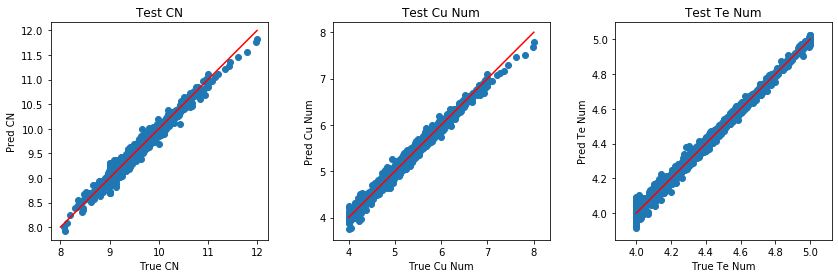

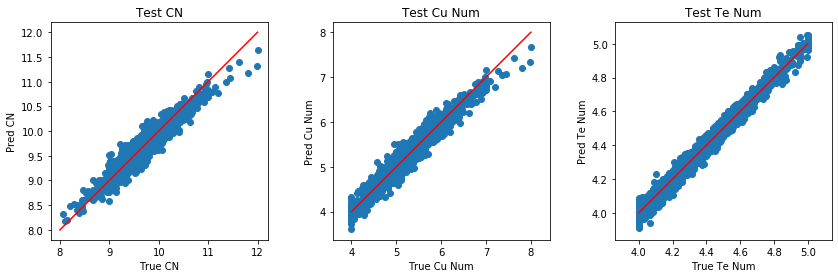

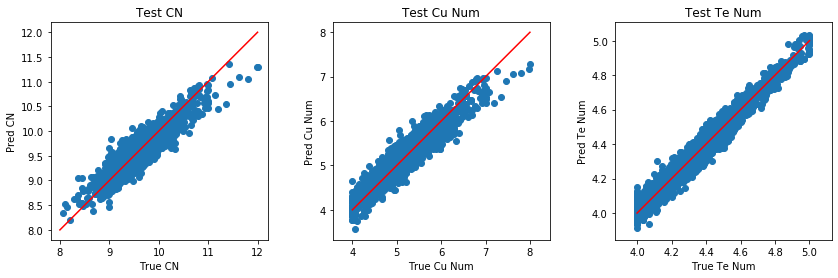

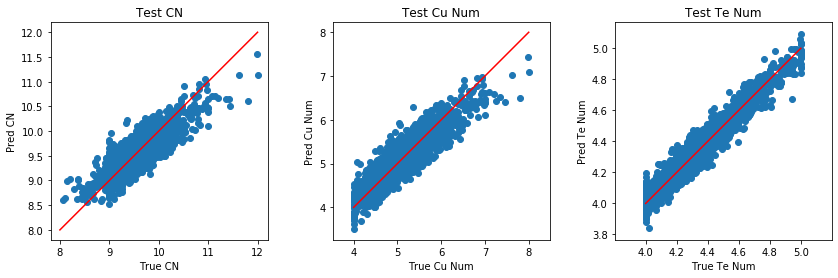

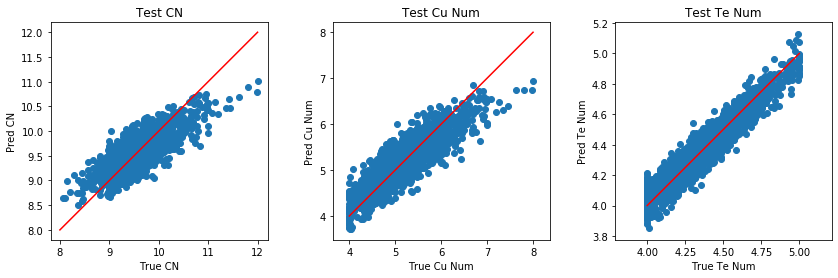

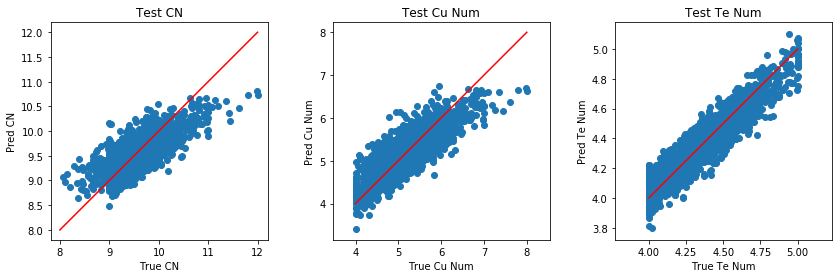

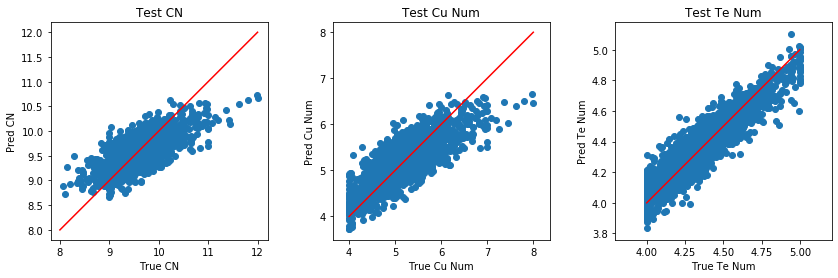

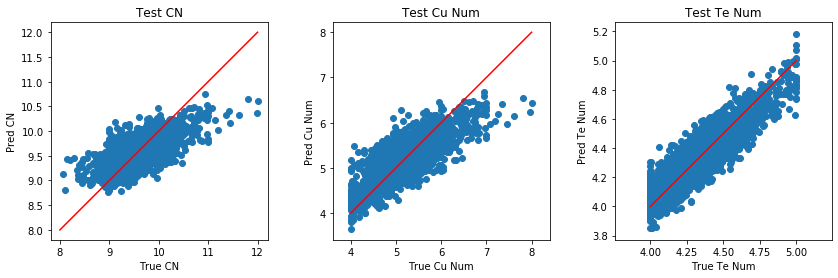

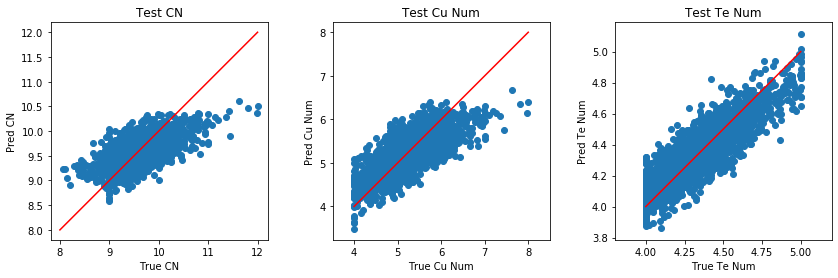

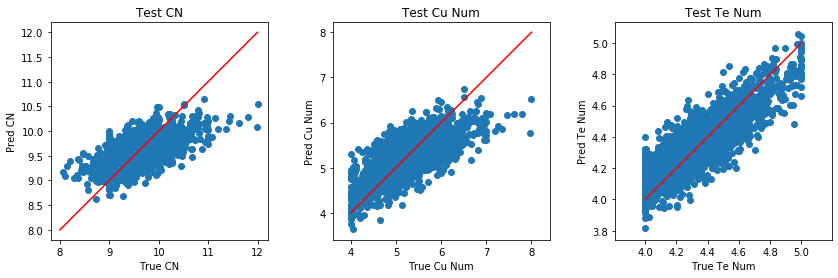

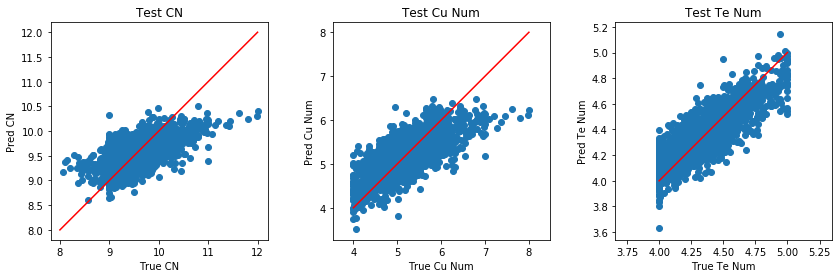

In [6]:
results_df_spectra = average_scores_spectra(iterations, df, Noise_STD):

# Repeated for training with first derivative.

           0
0   0.007529
1   0.000417
2   0.000400
3   0.000520
4   0.000589
5   0.000424
6   0.000399
7   0.000404
8   0.000617
9   0.000467
10  0.000455
11  0.000648
12  0.000506
13  0.001014
14  0.000564
15  0.000387
16  0.000489
17  0.000461
18  0.000522
19  0.000631
20  0.001008
21  0.000483
22  0.000458
23  0.000457
24  0.000459
25  0.000895
26  0.000727
27  0.000463
28  0.000859
29  0.000500
30  0.000439
31  0.000510
32  0.000729
33  0.000953
34  0.000520
35  0.000926
36  0.000936
37  0.000557
38  0.000615
39  0.001005
40  0.000986
41  0.000454
42  0.000488
43  0.000424
44  0.000949
45  0.000631
46  0.000648
47  0.000609
48  0.000886
49  0.000857
50  0.000409
51  0.000936
52  0.000701
53  0.000742
54  0.000878
55  0.000981
56  0.000932
57  0.000493
58  0.000983
59  0.000488
60  0.000624
61  0.000996
62  0.000934
63  0.000966
64  0.000933
65  0.000996
66  0.000940
67  0.000920
68  0.001014
69  0.000979
70  0.000913
71  0.000556
72  0.000917
73  0.000977
74  0.000952
75  0.000905

0.03834300611746921
training mse =  [0.10101683606007605, 0.11927318388739372, 0.006658361310339595]
testing mse = [0.10863311081708157, 0.11927318388739372, 0.006658361310339595]
training R2 = [0.464190699473192, 0.6408544625634712, 0.8705630203137248]
testing R2 = [0.45761117415630526, 0.6297770568760215, 0.8671337016064677]
           0
0   0.044082
1   0.040746
2   0.040755
3   0.040746
4   0.040726
5   0.040762
6   0.040741
7   0.040736
8   0.040742
9   0.040738
10  0.040730
11  0.040735
12  0.040751
13  0.040758
14  0.040777
15  0.040759
16  0.040753
17  0.040752
18  0.040781
19  0.040750
20  0.040753
21  0.040786
22  0.040757
23  0.040769
24  0.040775
25  0.040759
26  0.040779
27  0.040759
28  0.040760
29  0.040760
30  0.040740
31  0.040765
32  0.040751
33  0.040749
34  0.040753
35  0.040750
36  0.040761
37  0.040773
38  0.040796
39  0.040741
40  0.040764
41  0.040742
42  0.040775
43  0.040754
44  0.040760
45  0.040762
46  0.040767
47  0.040770
48  0.040783
49  0.040775
50  0.04

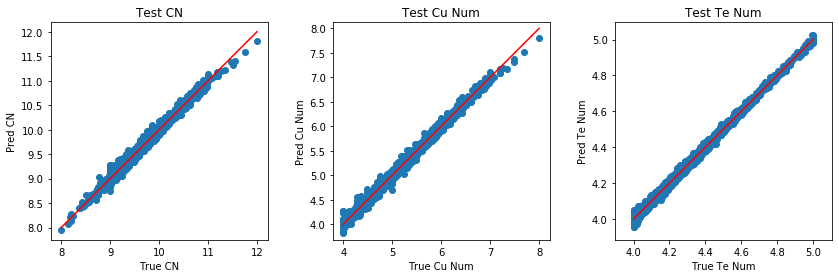

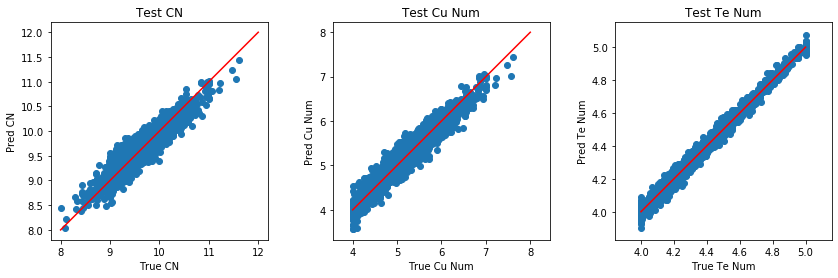

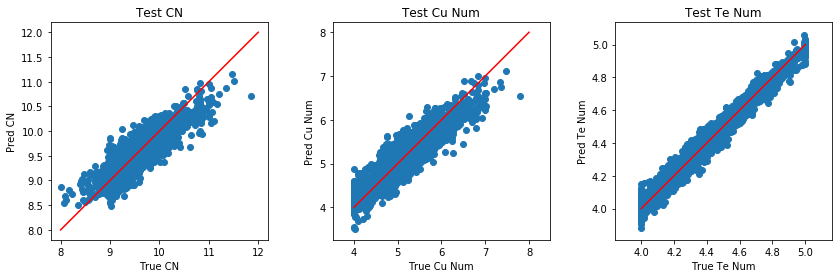

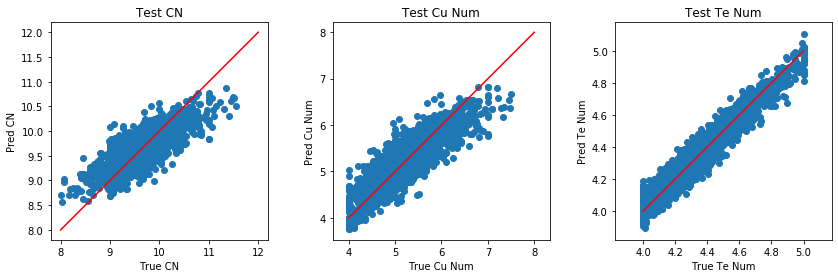

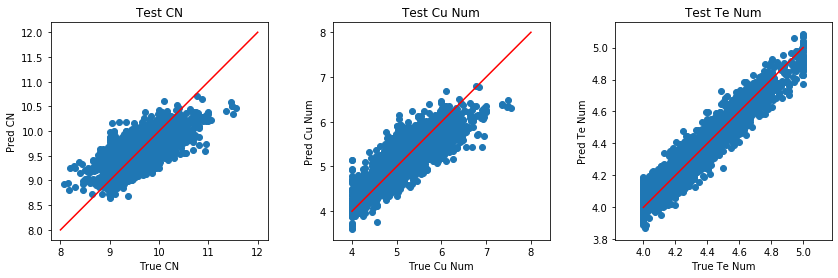

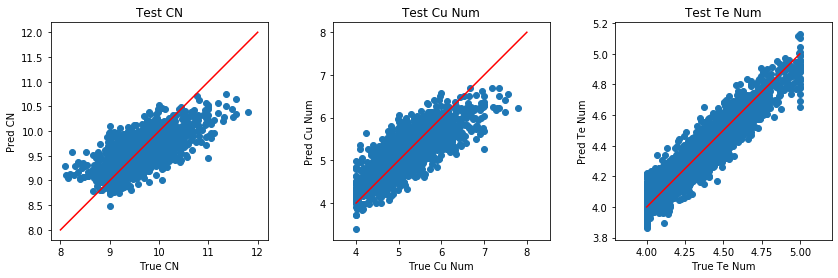

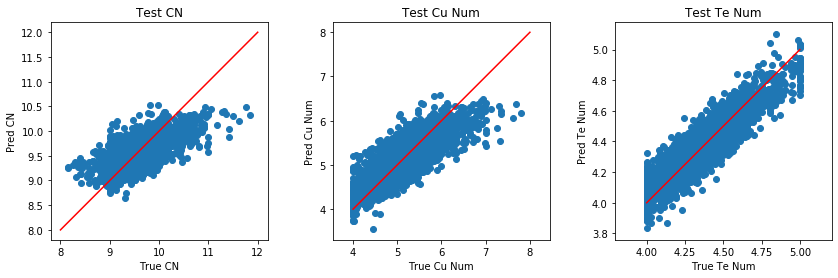

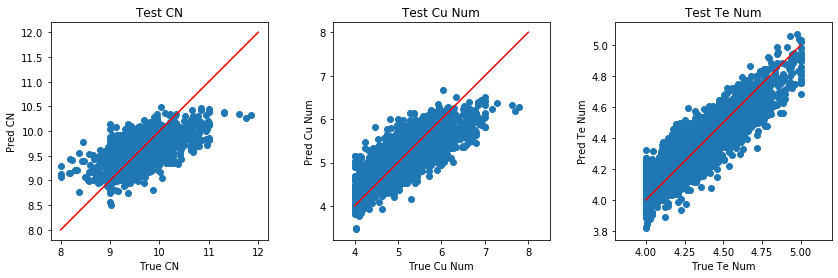

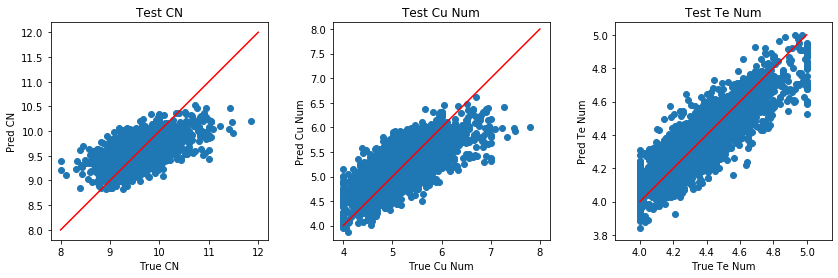

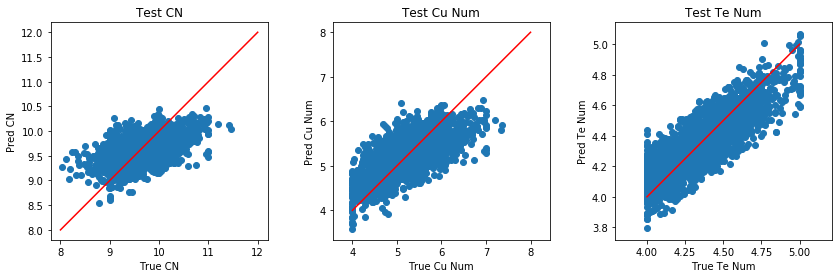

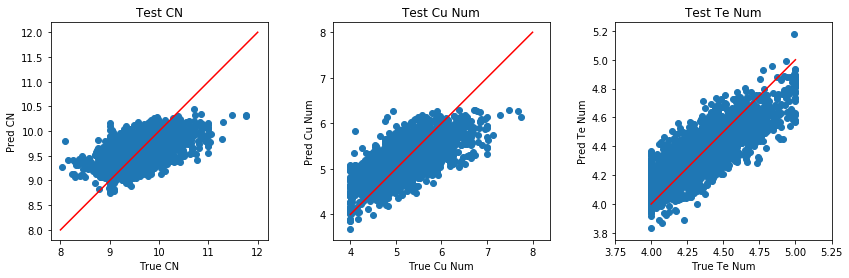

In [8]:
results_df_1 = average_scores_1(iterations, df, Noise_STD):

# Repeated for training with second derivative.

           0
0   0.008025
1   0.001135
2   0.000749
3   0.000680
4   0.001337
5   0.000872
6   0.000967
7   0.001037
8   0.000760
9   0.000729
10  0.001348
11  0.000903
12  0.000855
13  0.001192
14  0.000895
15  0.000930
16  0.000914
17  0.000793
18  0.000952
19  0.000914
20  0.000815
21  0.001191
22  0.001427
23  0.000792
24  0.001299
25  0.000910
26  0.001015
27  0.001001
28  0.001030
29  0.000874
30  0.000985
31  0.000899
32  0.000890
33  0.000838
34  0.000877
35  0.001391
36  0.001028
37  0.000796
38  0.000941
39  0.000868
40  0.000872
41  0.001187
42  0.001002
43  0.000951
44  0.000934
45  0.001264
46  0.000991
47  0.000996
48  0.000769
49  0.001009
50  0.001007
51  0.001159
52  0.000909
53  0.001756
54  0.001468
55  0.000871
56  0.000952
57  0.001731
58  0.000948
59  0.000979
60  0.000927
61  0.000913
62  0.000962
63  0.001677
64  0.001482
65  0.001067
66  0.000971
67  0.001103
68  0.000768
69  0.001577
70  0.001036
71  0.001222
72  0.001181
73  0.000873
74  0.001334
75  0.001270

0.041541351162174195
training mse =  [0.10515568962280565, 0.12194117280921123, 0.006872932670961384]
testing mse = [0.10802879853862642, 0.12194117280921123, 0.006872932670961384]
training R2 = [0.45056509887779284, 0.6347815848482564, 0.8651266209124285]
testing R2 = [0.4377475274668232, 0.6328621590394587, 0.8631306648054589]
           0
0   0.045475
1   0.045036
2   0.042659
3   0.044177
4   0.042588
5   0.042550
6   0.042666
7   0.042505
8   0.042515
9   0.042555
10  0.042552
11  0.042439
12  0.042476
13  0.042542
14  0.042449
15  0.042548
16  0.042497
17  0.042497
18  0.042482
19  0.042526
20  0.042423
21  0.042548
22  0.042501
23  0.042549
24  0.042466
25  0.042473
26  0.042439
27  0.042484
28  0.042556
29  0.042530
30  0.042433
31  0.042469
32  0.042405
33  0.042454
34  0.042502
35  0.042452
36  0.042499
37  0.042437
38  0.042463
39  0.042437
40  0.042512
41  0.042419
42  0.042454
43  0.042491
44  0.042446
45  0.042441
46  0.042471
47  0.042508
48  0.042535
49  0.042444
50  0.

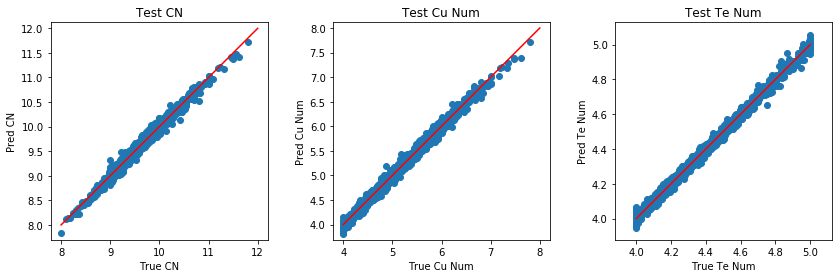

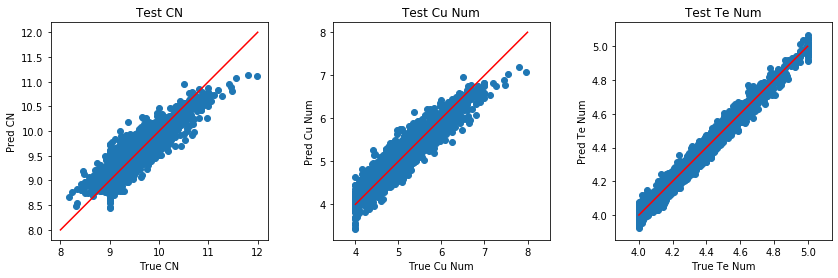

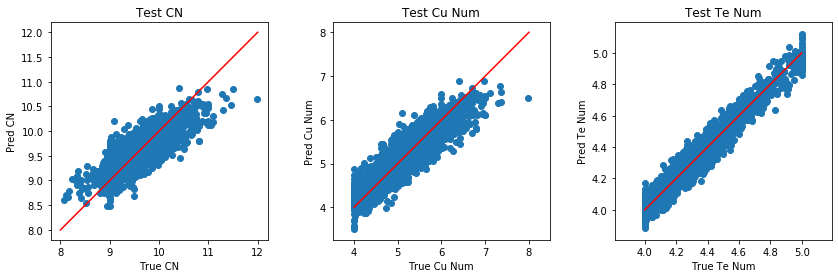

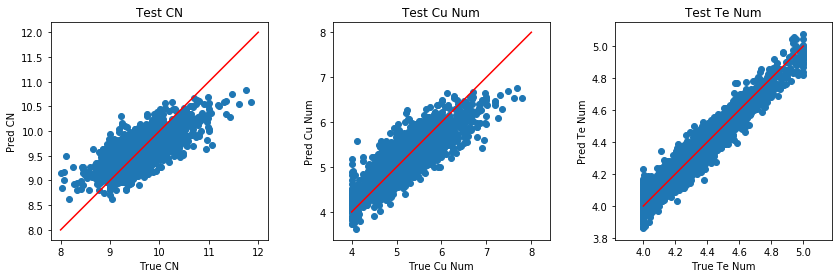

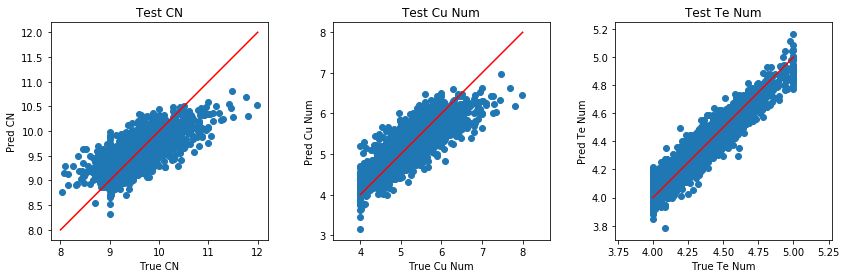

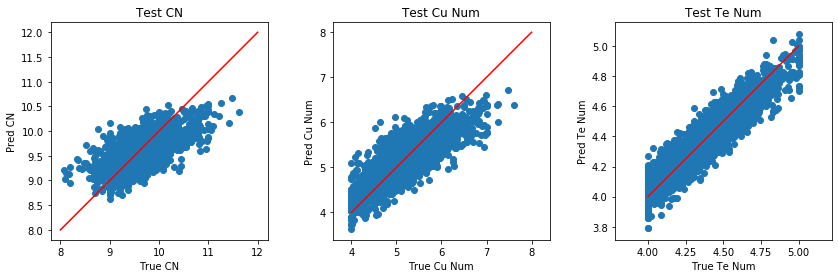

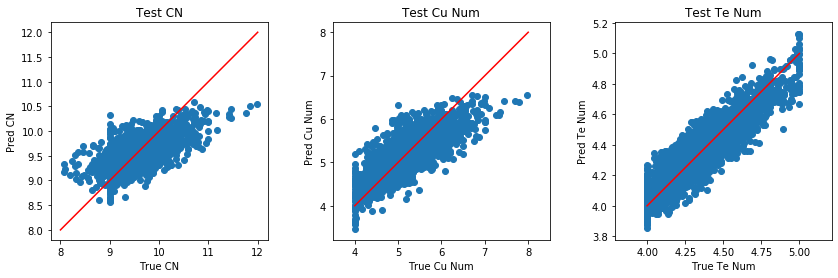

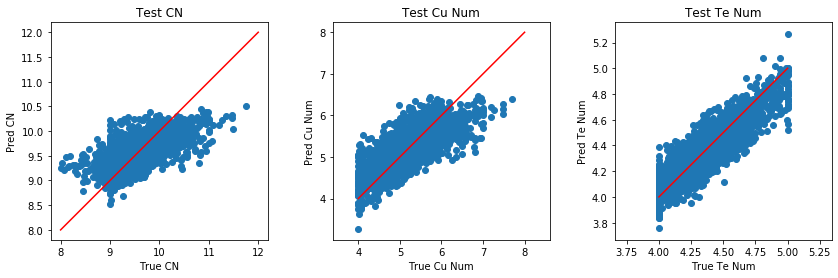

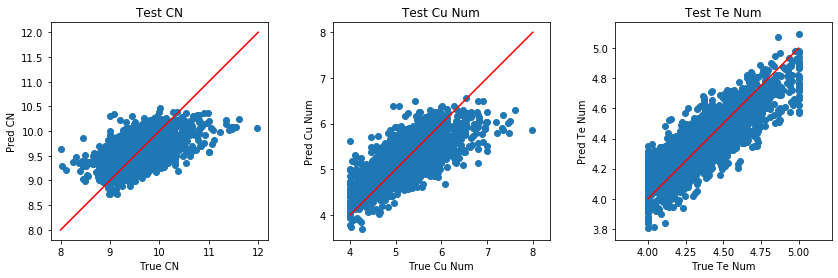

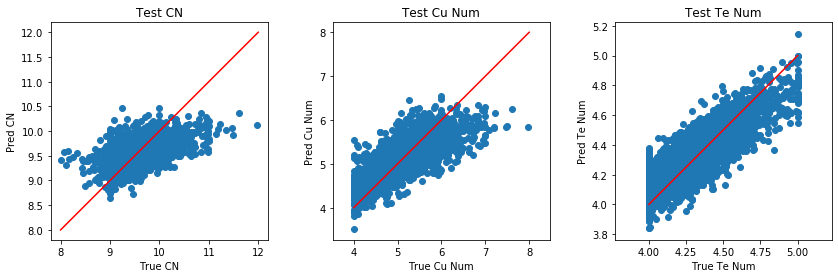

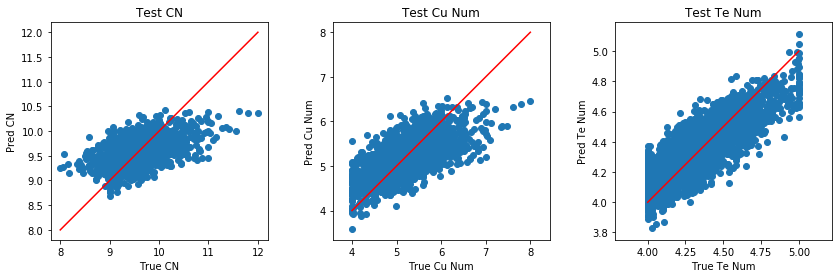

In [13]:
results_df_2 = average_scores_2(iterations, df, Noise_STD):

# Repeated for training with both the first and second derivative.

           0
0   0.007639
1   0.000332
2   0.000480
3   0.000377
4   0.000389
5   0.000374
6   0.000326
7   0.000371
8   0.000459
9   0.000384
10  0.000370
11  0.000331
12  0.000377
13  0.000378
14  0.000431
15  0.000477
16  0.000430
17  0.000373
18  0.000443
19  0.000474
20  0.000475
21  0.000501
22  0.000538
23  0.000503
24  0.000392
25  0.000464
26  0.000331
27  0.000572
28  0.000530
29  0.000585
30  0.000497
31  0.000549
32  0.000397
33  0.000547
34  0.000460
35  0.000462
36  0.000586
37  0.000456
38  0.000499
39  0.000531
40  0.000644
41  0.000479
42  0.000455
43  0.000550
44  0.000435
45  0.000402
46  0.000444
47  0.000468
48  0.000564
49  0.000573
50  0.000523
51  0.001031
52  0.000662
53  0.000588
54  0.000479
55  0.000465
56  0.000532
57  0.001035
58  0.000428
59  0.000592
60  0.000523
61  0.000409
62  0.000409
63  0.000604
64  0.000506
65  0.000530
66  0.000552
67  0.000547
68  0.001111
69  0.000526
70  0.001001
71  0.000461
72  0.000536
73  0.000575
74  0.000491
75  0.000493

0.038395274057770164
training mse =  [0.09917732192283313, 0.11801535272405991, 0.006635635965668896]
testing mse = [0.10291262137642748, 0.11801535272405991, 0.006635635965668896]
training R2 = [0.48497712332496157, 0.6500572835446649, 0.8720434603142704]
testing R2 = [0.4542804872060606, 0.6342206620957449, 0.8681427187490418]
           0
0   0.044733
1   0.041466
2   0.041451
3   0.041446
4   0.041468
5   0.041476
6   0.041450
7   0.041465
8   0.041454
9   0.041483
10  0.041476
11  0.041461
12  0.041471
13  0.041470
14  0.041486
15  0.041480
16  0.041496
17  0.041503
18  0.041506
19  0.041488
20  0.041486
21  0.041474
22  0.041489
23  0.041480
24  0.041485
25  0.041506
26  0.041500
27  0.041480
28  0.041509
29  0.041510
30  0.041529
31  0.041490
32  0.041503
33  0.041498
34  0.041483
35  0.041502
36  0.041534
37  0.041498
38  0.041498
39  0.041483
40  0.041508
41  0.041495
42  0.041503
43  0.041509
44  0.041509
45  0.041495
46  0.041516
47  0.041512
48  0.041532
49  0.041496
50  0.

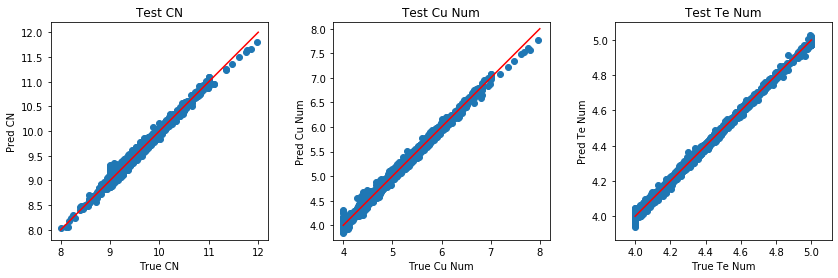

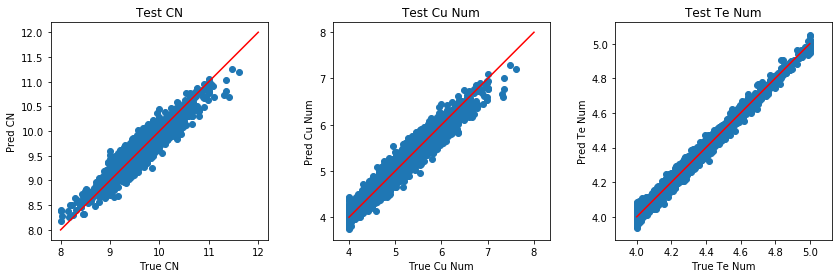

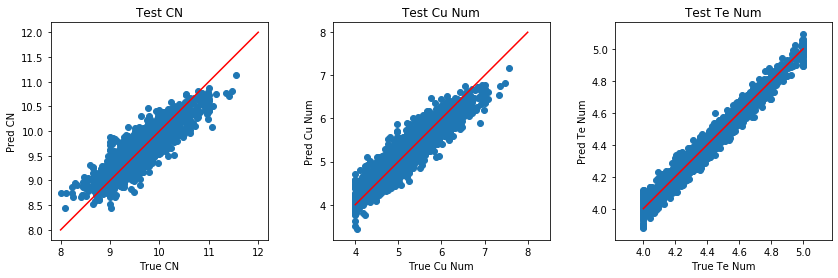

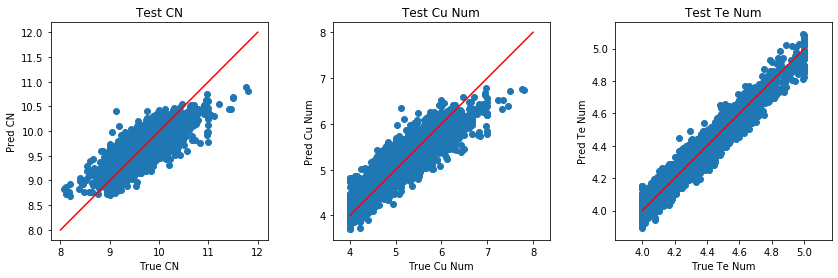

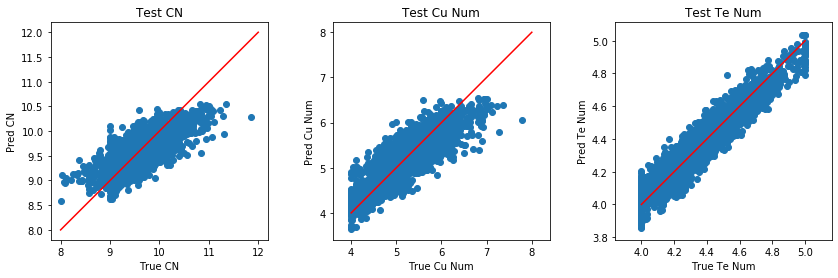

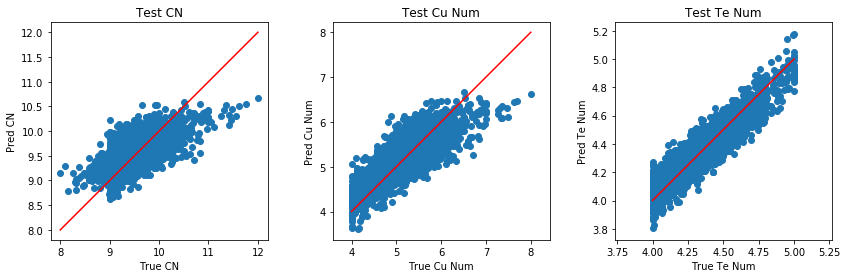

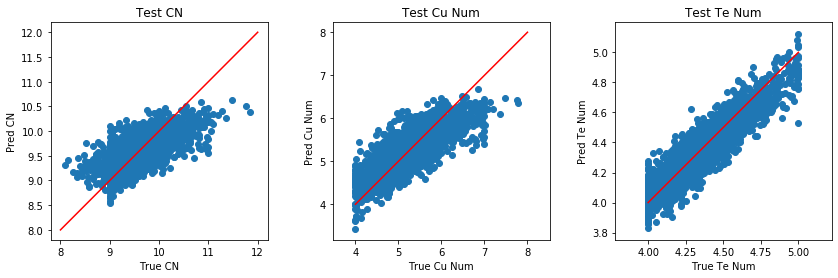

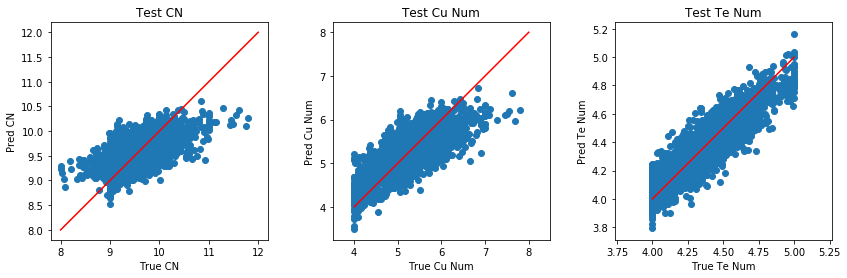

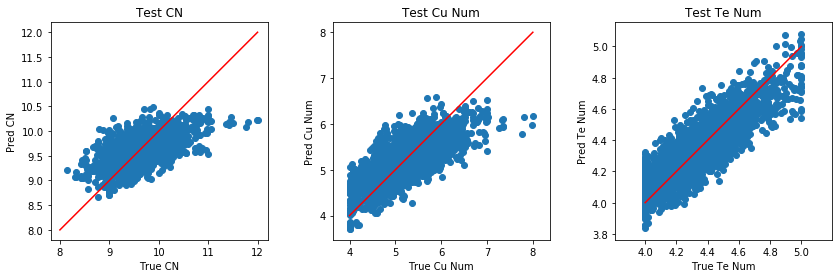

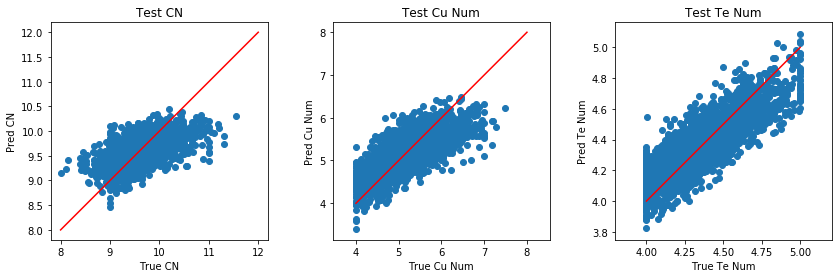

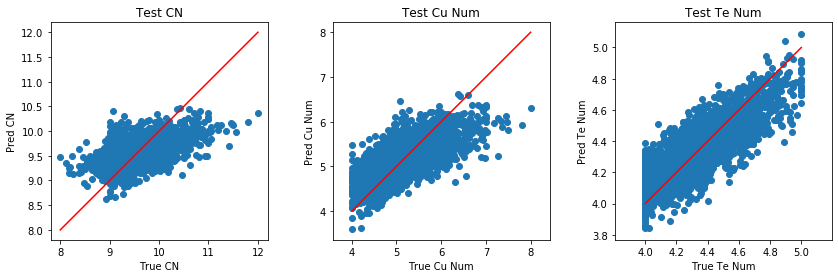

In [10]:
results_df_1_2 = average_scores_1_2(iterations, df, Noise_STD):

# Repeated for training with first derivative.

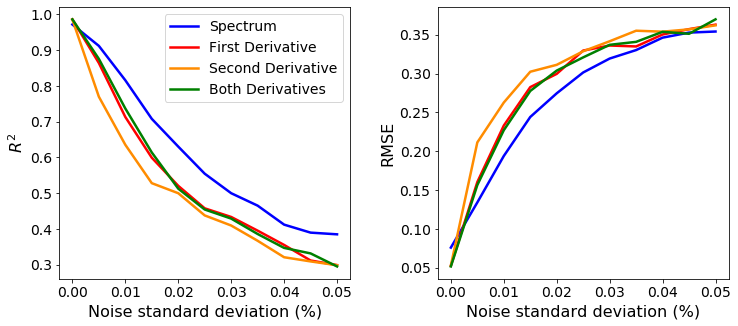

In [15]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_CN'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_CN'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_CN'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_CN'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise Standard Deviation', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_CN'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_CN'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_CN'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_CN'], c='green', lw=2.5)
ax2.set_xlabel('Noise Standard Deviation', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

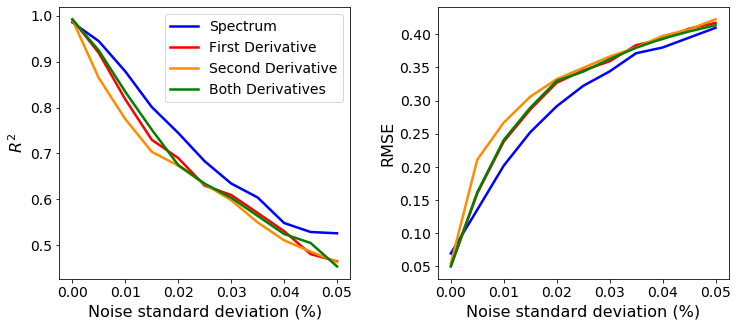

In [16]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_Cu'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_Cu'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_Cu'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_Cu'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise Standard Deviation', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_Cu'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_Cu'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_Cu'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_Cu'], c='green', lw=2.5)
ax2.set_xlabel('Noise Standard Deviation', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

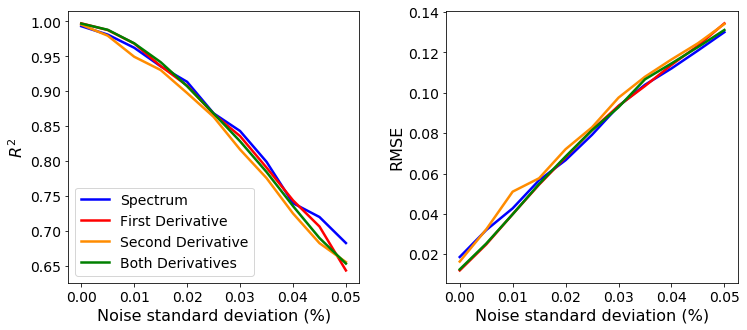

In [17]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_Te'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_Te'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_Te'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_Te'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise Standard Deviation', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_Te'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_Te'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_Te'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_Te'], c='green', lw=2.5)
ax2.set_xlabel('Noise Standard Deviation', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()